<a href="https://colab.research.google.com/github/yashi2606/Fintech/blob/main/ModelTraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install numpy pandas aif360[Reductions] feature_engine xgboost lime scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 378.6/378.6 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.7/259.7 kB 14.9 MB/s eta 0:00:00
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=f08840e720c8b5336e6d448c0e960ddacff45df39a93daba0028fa023f9cecc1
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:
import pandas as pd
import numpy as np
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.impute import KNNImputer , SimpleImputer
from sklearn.feature_selection import RFECV
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from feature_engine.outliers import Winsorizer
np.random.seed(42)
n_delivery = 1500
n_freelancer = 1500

pip install 'aif360[inFairness]'


In [ ]:
# Add realistic dates and IDs
join_dates = pd.date_range(end='today', periods=n_delivery+n_freelancer, freq='D').tolist()
np.random.shuffle(join_dates)
worker_ids = [f'DEL_{i}' for i in range(n_delivery)] + [f'FREL_{i}' for i in range(n_freelancer)]

### Delivery Workers Dataset ###
delivery = pd.DataFrame({
    'worker_id': worker_ids[:n_delivery],
    'rating': np.clip(np.round(np.random.normal(loc=4.2, scale=0.3, size=n_delivery)), 1, 5),
    'jobs_per_week': np.random.randint(60, 80, size=n_delivery),
    'missed_jobs': np.random.poisson(2, size=n_delivery),
    'months_on_platform': np.random.randint(2, 48, size=n_delivery),
    'has_previous_loans': np.random.binomial(1, 0.3, size=n_delivery),
    'previous_loan_performance': np.random.beta(2, 5, size=n_delivery),
    'region': np.random.choice(['urban', 'semi-urban', 'rural'], size=n_delivery, p=[0.6, 0.3, 0.1]),
    'loan_amount': np.random.randint(3000, 20000, size=n_delivery),
    'loan_term_weeks': np.random.randint(4, 24, size=n_delivery),
    'join_date': join_dates[:n_delivery],
    'last_job_date': pd.to_datetime('today') - pd.to_timedelta(np.random.randint(1, 14, size=n_delivery), unit='D'),
    'segment': 'delivery'
})


In [ ]:
### Freelancers Dataset ###
freelancers = pd.DataFrame({
    'worker_id': worker_ids[n_delivery:],
    'rating': np.clip(np.round(np.random.normal(loc=4.5, scale=0.2, size=n_freelancer)), 1, 5),
    'jobs_per_week': np.random.randint(2, 10, size=n_freelancer),
    'missed_jobs': np.random.poisson(0.3, size=n_freelancer),
    'months_on_platform': np.random.randint(6, 60, size=n_freelancer),
    'has_previous_loans': np.random.binomial(1, 0.4, size=n_freelancer),
    'previous_loan_performance': np.random.beta(3, 4, size=n_freelancer),
    'region': np.random.choice(['urban', 'semi-urban', 'rural'], size=n_freelancer, p=[0.5, 0.3, 0.2]),
    'loan_amount': np.random.randint(10000, 50000, size=n_freelancer),
    'loan_term_weeks': np.random.randint(12, 52, size=n_freelancer),
    'join_date': join_dates[n_delivery:],
    'last_job_date': pd.to_datetime('today') - pd.to_timedelta(np.random.randint(1, 30, size=n_freelancer), unit='D'),
    'segment': 'freelancer'
})

# Income generation with segment-specific parameters
delivery['weekly_income'] = (delivery['jobs_per_week'] *
                           np.random.normal(loc=100, scale=10, size=n_delivery) +
                           np.random.normal(0, 80, size=n_delivery)).astype(int)

freelancers['weekly_income'] = (freelancers['jobs_per_week'] *
                              np.random.normal(loc=3000, scale=1000, size=n_freelancer) +
                              np.random.normal(0, 150, size=n_freelancer)).astype(int)

### Combine Both ###
data = pd.concat([delivery, freelancers], ignore_index=True)

In [ ]:
# 2. Advanced Feature Engineering
def create_features(df):
    # Basic features
    df['income_per_job'] = (df['weekly_income'] / df['jobs_per_week']).round(2)
    df['miss_rate'] = (df['missed_jobs'] / df['jobs_per_week']).round(4)
    df['loan_to_income_ratio'] = (df['loan_amount'] / (df['weekly_income'] * df['loan_term_weeks'] + 1e-5)).round(2)

    # Financial stability features
    df['dscr'] = (df['weekly_income'] * 4) / (df['loan_amount'] / df['loan_term_weeks'])

    # Behavioral features
    df['tenure_engagement'] = df['jobs_per_week'] / df['months_on_platform']
    df['rating_std'] = df.groupby('segment')['rating'].transform('std').fillna(0)

    # Time-based features
    df['join_month'] = pd.to_datetime(df['join_date']).dt.month
    df['is_holiday_season'] = df['join_month'].isin([11, 12]).astype(int)
    df['days_since_last_job'] = (pd.to_datetime('today') - pd.to_datetime(df['last_job_date'])).dt.days
    df['total_jobs_done'] = df['jobs_per_week'] * df['months_on_platform'] * 4

    return df

data = create_features(data)


In [ ]:
# Inject NaNs into 2% of rows in key cols
for col in ['rating', 'weekly_income', 'loan_amount']:
    data.loc[data.sample(frac=0.02).index, col] = np.nan

#  Use ONLY KNN Imputer
imputer = KNNImputer(n_neighbors=5)
numeric_cols = data.select_dtypes(include=np.number).columns
data[numeric_cols] = imputer.fit_transform(data[numeric_cols])

# PreProcessing/Cleaning data

In [ ]:
def preprocess_data(data, target_col=None):
    """
    Preprocess gig worker data for loan eligibility.
    Steps:
    1. Handle outliers using Winsorization
    2. Impute missing values
    3. Normalize numeric data
    4. One-hot encode categorical variables
    Returns: processed DataFrame and the pipeline
    """
    df = data.copy()

    # Step 1: Basic cleanup using Winsorization (more robust than .clip)
    for col in ['weekly_income', 'loan_amount', 'income_per_job']:
        if col in df.columns:
            df[col] = Winsorizer(capping_method='iqr', tail='both').fit_transform(df[[col]])

    # Step 2: Clip 'miss_rate' if it exists
    if 'miss_rate' in df.columns:
        df['miss_rate'] = df['miss_rate'].clip(upper=1)
    else:
        # Handle missing 'miss_rate' by creating a default column with 0
        df['miss_rate'] = 0

    # Step 3: Define features, ensuring columns exist
    numeric_features = [
        'rating', 'jobs_per_week', 'months_on_platform',
        'weekly_income', 'income_per_job', 'miss_rate',
        'loan_to_income_ratio', 'dscr', 'tenure_engagement',
        'days_since_last_job', 'total_jobs_done'
    ]
    categorical_features = ['region', 'has_previous_loans']
    binary_features = ['is_holiday_season']

    # Ensure features are present in the data
    numeric_features = [col for col in numeric_features if col in df.columns]
    categorical_features = [col for col in categorical_features if col in df.columns]
    binary_features = [col for col in binary_features if col in df.columns]

    # Step 4: Transformers for numeric and categorical features
    numeric_transformer = Pipeline([
        ('imputer', KNNImputer(n_neighbors=5)),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    # Step 5: ColumnTransformer with conditional columns
    preprocessor = ColumnTransformer([
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('bin', 'passthrough', binary_features)
    ], remainder='drop')

    # Step 6: Preprocess data
    drop_cols = ['worker_id', 'join_date', 'last_job_date']
    if target_col:
        drop_cols.append(target_col)

    X = df.drop(columns=drop_cols, errors='ignore')
    X_processed = preprocessor.fit_transform(X)

    # Step 7: Rebuild DataFrame with processed features
    cat_cols = preprocessor.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(categorical_features)
    all_cols = numeric_features + list(cat_cols) + binary_features
    processed_df = pd.DataFrame(X_processed, columns=all_cols)

    # Step 8: Sanity checks
    assert not processed_df.isna().any().any(), "NaNs found after preprocessing"
    assert np.isfinite(processed_df.values).all(), "Non-finite values found"

    return processed_df, preprocessor



In [ ]:
from datetime import datetime

def calculate_tiered_eligibility(data, config=None, market_condition=0):
    df = data.copy()

    # Default configuration with realistic rules and proper scaling
    if config is None:
        config = {
            "tiers": {
                "Low": 80,    # Adjusted to match 100-point scale
                "Medium": 60,
                "High": 40,
                "Rejected": 0
            },
            "rules": [
                {
                    "name": "income_stability",
                    "metrics": ["weekly_income", "income_per_job"],
                    "calculation": lambda df: np.where(
                        (df['weekly_income'] > 3000) & (df['income_per_job'] > 75), 30,
                        np.where(df['weekly_income'] > 2000, 20, 10)),
                    "base_weight": 1.0,  # Changed to 1.0 since we're using raw points
                    "market_sensitive": True,
                    "group": "Financial",
                    "dependencies": {"minimum_score": 5}
                },
                {
                    "name": "job_stability",
                    "metrics": ["job_stability", "jobs_per_week"],
                    "calculation": lambda df: np.where(
                        df['job_stability'] >= 7, 25,
                        np.where(df['job_stability'] >= 5, 15, 5)),
                    "base_weight": 1.0,
                    "group": "Reliability"
                },
                {
                    "name": "loan_history",
                    "metrics": ["has_previous_loans", "previous_loan_performance"],
                    "calculation": lambda df: np.where(
                        (df['has_previous_loans'] == 1) & (df['previous_loan_performance'] > 0.7), 20,
                        np.where(df['has_previous_loans'] == 0, 15, 5)),
                    "base_weight": 1.0,
                    "group": "Financial"
                },
                {
                    "name": "platform_tenure",
                    "metrics": ["months_on_platform"],
                    "calculation": lambda df: np.where(
                        df['months_on_platform'] > 24, 15,
                        np.where(df['months_on_platform'] > 12, 10, 5)),
                    "base_weight": 1.0,
                    "group": "Stability"
                },
                {
                    "name": "activity_recency",
                    "metrics": ["last_job_date"],
                    "calculation": lambda df: np.where(
                        (pd.to_datetime('today') - df['last_job_date']).dt.days <= 7, 10,
                        np.where((pd.to_datetime('today') - df['last_job_date']).dt.days <= 14, 5, 0)),
                    "base_weight": 1.0,
                    "group": "Activity"
                }
            ],
            "auto_adjust": {
                "enabled": True,
                "target_approval_rate": 0.5,
                "max_adjustment": 10
            },
            "peer_comparison": True
        }

    # ========= Rule Validation =========
    def validate_rules(config, df_columns):
        missing_metrics = []
        for rule in config['rules']:
            for metric in rule['metrics']:
                if metric not in df_columns:
                    missing_metrics.append((rule['name'], metric))
        if missing_metrics:
            print(f"Warning: Missing metrics for rules: {missing_metrics}")

    validate_rules(config, df.columns)

    # ========= Required Columns =========
    if 'has_previous_loans' in df.columns and 'previous_loan_performance' not in df.columns:
        df['previous_loan_performance'] = np.where(df['has_previous_loans'] == 1, 0.9, 0.5)

    if 'region_urban' not in df.columns and 'region' in df.columns:
        df['region_urban'] = df['region'].apply(lambda x: 1 if x == 'urban' else 0)

    if 'region_semi-urban' not in df.columns and 'region' in df.columns:
        df['region_semi-urban'] = df['region'].apply(lambda x: 1 if x == 'semi-urban' else 0)

    # ========= Trend Metrics =========
    if 'income_trend' not in df.columns and 'weekly_income' in df.columns:
        df['income_trend'] = df.groupby('worker_id')['weekly_income'].transform(
            lambda x: x.rolling(3, min_periods=1).mean().pct_change().fillna(0)
        )

    if 'rating_trend' not in df.columns and 'rating' in df.columns:
        df['rating_trend'] = df.groupby('worker_id')['rating'].transform(
            lambda x: x.rolling(3, min_periods=1).mean().diff().fillna(0)
        )

    # ========= Peer Normalization =========
    if config.get('peer_comparison', False):
        for metric in ['weekly_income', 'jobs_per_week']:
            if metric in df.columns:
                df[f'{metric}_percentile'] = df[metric].rank(pct=True) * 50

    # ========= Dynamic Weights =========
    for rule in config['rules']:
        rule['weight'] = rule['base_weight']
        if rule.get('market_sensitive', False):
            rule['weight'] += market_condition * 0.05

    # ========= Init Scoring =========
    df['risk_score'] = 0.0
    df['rule_contributions'] = [{} for _ in range(len(df))]
    df['failed_dependencies'] = [[] for _ in range(len(df))]

    for rule in config['rules']:
        try:
            points = rule['calculation'](df)
            contribution = points * rule['weight']

            df['risk_score'] += contribution

            for idx in df.index:
                df.at[idx, 'rule_contributions'][rule['name']] = {
                    'points': float(points[idx]),
                    'contribution': float(contribution[idx]),
                    'group': rule['group']
                }

                if 'dependencies' in rule:
                    if points[idx] < rule['dependencies']['minimum_score']:
                        df.at[idx, 'failed_dependencies'].append(rule['name'])
        except Exception as e:
            print(f"Error processing rule {rule['name']}: {str(e)}")
            continue

    df['risk_score'] = df['risk_score'].clip(0, 100)

    # ========= Matrix Tiering =========
    def assign_tier(row):
        total_score = row['risk_score']
        failed = row['failed_dependencies']

        # Critical rules that lead to automatic rejection
        critical_rules = ['income_stability', 'job_stability']
        critical_failures = any(rule in failed for rule in critical_rules)

        if critical_failures:
            return 'Rejected'
        elif total_score >= config['tiers']['Low']:
            return 'Low'
        elif total_score >= config['tiers']['Medium']:
            return 'Medium'
        elif total_score >= config['tiers']['High']:
            return 'High'
        return 'Rejected'

    df['risk_tier'] = df.apply(assign_tier, axis=1)

    # ========= Auto-Adjust Thresholds =========
    if config.get('auto_adjust', {}).get('enabled', False):
        current_rate = (df['risk_tier'] == 'Low').mean()
        target = config['auto_adjust']['target_approval_rate']
        step = 1
        adjustments = 0

        while abs(current_rate - target) > 0.05 and adjustments < config['auto_adjust']['max_adjustment']:
            if current_rate < target:
                config['tiers']['Low'] -= step
            else:
                config['tiers']['Low'] += step

            config['tiers']['Low'] = np.clip(config['tiers']['Low'],
                                          config['tiers']['Medium'] + 5,
                                          95)

            df['risk_tier'] = df.apply(assign_tier, axis=1)
            current_rate = (df['risk_tier'] == 'Low').mean()
            adjustments += 1

    # ========= Explanation =========
    def generate_explanations(row):
        reasons = []
        contribs = row['rule_contributions']

        if row['risk_tier'] == 'Low':
            reasons.append("Excellent financial stability and reliability metrics.")
        elif row['risk_tier'] == 'Medium':
            reasons.append("Good financial metrics with acceptable reliability.")
        elif row['risk_tier'] == 'High':
            reasons.append("Basic financial requirements met but needs monitoring.")
        else:
            reasons.append("Critical financial stability requirements not met.")

        if row['failed_dependencies']:
            critical = [r for r in row['failed_dependencies'] if r in ['income_stability', 'job_stability']]
            if critical:
                reasons.append(f"Critical requirements failed: {', '.join(critical)}")
            else:
                reasons.append(f"Non-critical requirements failed: {', '.join(row['failed_dependencies'])}")

        if 'income_trend' in contribs and contribs['income_trend']['points'] < 0:
            reasons.append("Negative income trend detected.")

        if 'rating_trend' in contribs and contribs['rating_trend']['points'] < 0:
            reasons.append("Negative rating trend detected.")

        return "; ".join(reasons) if reasons else "Approved with no concerns"

    df['explanation'] = df.apply(generate_explanations, axis=1)

    # ========= Metadata =========
    df['scoring_version'] = '4.0-final'
    df['last_scored'] = datetime.now().isoformat()
    df['market_condition'] = market_condition

    return df, config


In [ ]:

df = pd.DataFrame(data)

# Run the eligibility calculation
result_df, config = calculate_tiered_eligibility(df)

# Show the result
print(result_df[['worker_id', 'risk_score', 'risk_tier', 'explanation']])
print(result_df.head())


Error processing rule job_stability: 'job_stability'
      worker_id  risk_score risk_tier  \
0         DEL_0        65.0    Medium   
1         DEL_1        55.0      High   
2         DEL_2        60.0    Medium   
3         DEL_3        65.0    Medium   
4         DEL_4        45.0      High   
...         ...         ...       ...   
2995  FREL_1495        65.0    Medium   
2996  FREL_1496        60.0    Medium   
2997  FREL_1497        70.0       Low   
2998  FREL_1498        50.0      High   
2999  FREL_1499        70.0       Low   

                                            explanation  
0     Good financial metrics with acceptable reliabi...  
1     Basic financial requirements met but needs mon...  
2     Good financial metrics with acceptable reliabi...  
3     Good financial metrics with acceptable reliabi...  
4     Basic financial requirements met but needs mon...  
...                                                 ...  
2995  Good financial metrics with acceptable rel

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# 1. Prepare the data - using only columns that exist in your DataFrame
features = ['rating', 'jobs_per_week', 'missed_jobs', 'months_on_platform',
           'has_previous_loans', 'previous_loan_performance']  # Removed risk_score

X = result_df[features]  # Features
y = result_df['risk_tier']  # Target variable

# 2. Split into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Train the model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# 4. Evaluate the model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# 5. Make predictions on new data (example)
new_worker = {
    'rating': 4.5,
    'jobs_per_week': 65,
    'missed_jobs': 1,
    'months_on_platform': 24,
    'has_previous_loans': 0,
    'previous_loan_performance': 0.7
}

new_data = pd.DataFrame([new_worker])
prediction = model.predict(new_data)
print(f"\nPredicted risk tier for new worker: {prediction[0]}")


              precision    recall  f1-score   support

        High       0.74      0.81      0.77       215
         Low       0.43      0.43      0.43        70
      Medium       0.73      0.68      0.70       315

    accuracy                           0.70       600
   macro avg       0.63      0.64      0.64       600
weighted avg       0.70      0.70      0.70       600


Predicted risk tier for new worker: Medium


Classification Report:
              precision    recall  f1-score   support

        High       0.74      0.81      0.77       215
         Low       0.43      0.43      0.43        70
      Medium       0.73      0.68      0.70       315

    accuracy                           0.70       600
   macro avg       0.63      0.64      0.64       600
weighted avg       0.70      0.70      0.70       600



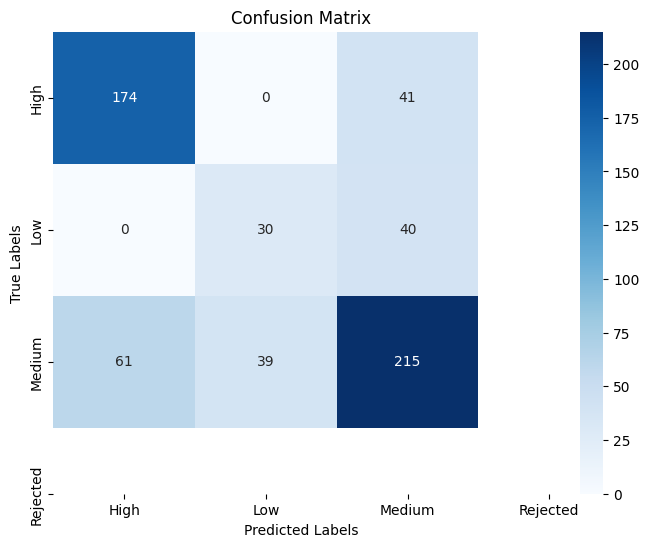

Weighted Precision: 0.6974
Weighted Recall: 0.6983
Weighted F1-Score: 0.6969

Feature Importance:
 months_on_platform           0.290617
previous_loan_performance    0.244584
has_previous_loans           0.231623
jobs_per_week                0.155117
missed_jobs                  0.050474
rating                       0.027585
dtype: float64


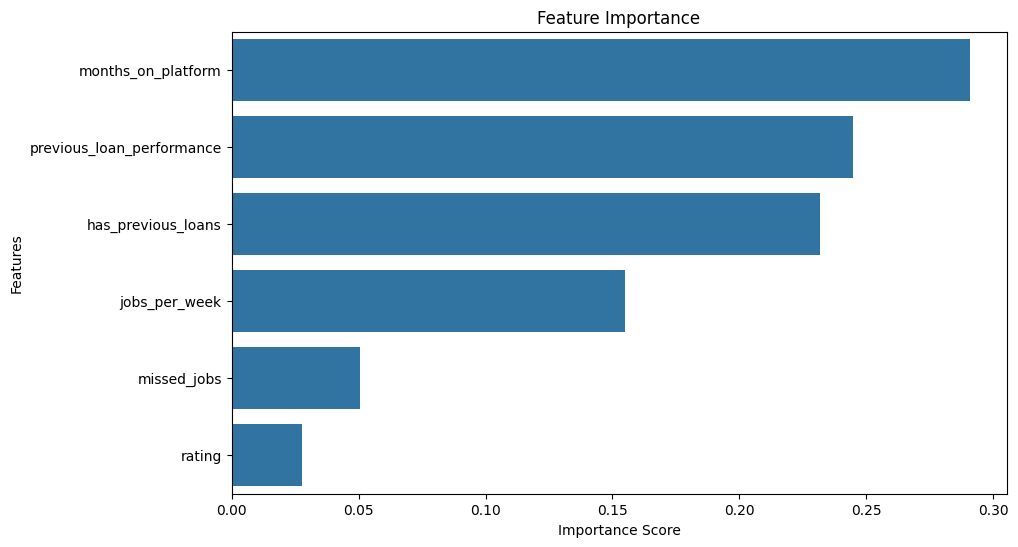

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_risk_model(df, features, target_column='risk_tier', test_size=0.2, random_state=42):
    """
    Trains a RandomForestClassifier and evaluates its performance on risk tier prediction.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        features (list): List of feature column names.
        target_column (str): Name of the target column.
        test_size (float): Proportion of the dataset to include in the test split.
        random_state (int): Seed for reproducibility.
    """

    # 1. Prepare the data
    X = df[features]
    y = df[target_column]

    # 2. Split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # 3. Train the model
    model = RandomForestClassifier(random_state=random_state)
    model.fit(X_train, y_train)

    # 4. Make predictions
    y_pred = model.predict(X_test)

    # 5. Classification Report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # 6. Confusion Matrix Visualization
    plt.figure(figsize=(8, 6))
    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=model.classes_, yticklabels=model.classes_)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

    # 7. Weighted Precision, Recall, and F1-Score
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"Weighted Precision: {precision:.4f}")
    print(f"Weighted Recall: {recall:.4f}")
    print(f"Weighted F1-Score: {f1:.4f}")

    #8. Feature Importance
    feature_importance = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)
    print("\nFeature Importance:\n", feature_importance)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=feature_importance, y=feature_importance.index)
    plt.title("Feature Importance")
    plt.xlabel("Importance Score")
    plt.ylabel("Features")
    plt.show()

# Example usage (assuming 'result_df' is your DataFrame):
features = ['rating', 'jobs_per_week', 'missed_jobs', 'months_on_platform', 'has_previous_loans', 'previous_loan_performance']
evaluate_risk_model(result_df, features)

In [ ]:
import joblib

# Assuming 'model' is your trained model
joblib.dump(model, 'model.pkl')
from google.colab import files
files.download('model.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>